In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Magnetic constant (SI); used by Biot–Savart evaluation
mu_0 = 4 * np.pi * 1e-7

# Conductor diameter for AWG24 (metres); governs axial coil length via turn count
d = 0.51054e-3

# Region where the optimizer matches fields (mm)
z_solve_min = -65.5
z_solve_max = -5
z_solve_values = np.linspace(z_solve_min, z_solve_max, 1000)

# Plotting window (mm) and y-limits (G) for consistent visualisation
z_min, z_max = -80, 13
z_values = np.linspace(z_min, z_max, 1000)
B_min, B_max = -5, 10

# Sample vertical extent used for highlighting/metrics (mm)
z_top_sample = z_solve_max
z_bottom_sample = z_solve_min

# Seed coil set (reasonable prior); parameters per coil: current (mA), radius (mm),
# turns (count), z-offset (mm), layers (count)
coil_params = [
    {'a': 355,  'R': 6.82, 'n': 21, 'z': -59.18, 'm': 1},
    {'a': 5,    'R': 2.5,  'n': 5,  'z': -66.94, 'm': 1},
    {'a': -160, 'R': 6.54, 'n': 8,  'z': -25.98, 'm': 1},
    {'a': 120,  'R': 7.54, 'n': 44, 'z': 0.00,   'm': 1},
    {'a': 160,  'R': 3.5,  'n': 5,  'z': -2.22,  'm': 1},
]

# Flattened initial guess vector in the order [a, R, n, z, m] × n_coils
initial_guesses = np.array([[c['a'], c['R'], c['n'], c['z'], c['m']] for c in coil_params]).flatten()


In [2]:
# External field polynomial coefficients (Gauss) evaluated on z in metres
external_field_coeffs = [
    -0.05859,
    47.66114,
    -4865.06371,
    -146097.83504,
    4260040.3748,
    3.04437e8,
    -8.75637e9,
    -7.65903e10,
    1.46997e12
]

def external_field(z_mm: np.ndarray) -> np.ndarray:
    """
    Evaluate reference B(z) in Gauss.
    z_mm : position in millimetres; internally converted to metres and shifted by 31.5 mm.
    """
    z_m = (z_mm / 1000.0) + 31.5e-3                    # mm→m plus calibration offset in SI
    # Horner-like explicit sum; vectorised and stable for our order/range
    return sum(coeff * (z_m ** i) for i, coeff in enumerate(external_field_coeffs))

# Per-coil parameter bounds:
#   a (mA), R (mm), n (turns), z (mm), m (layers)
coil_bounds = [
    (-500, 500),   # current (mA): sign allowed for direction
    (3.5, 20),     # radius (mm): mechanical clearance
    (1, 100),      # turns (count): manufacturable range
    (-98, -2),     # axial placement (mm): stays below zero in this design
    (1, 5)         # layers (count): small integer band
]

# Repeat bounds for each coil to match the flattened parameter vector
bounds = coil_bounds * len(coil_params)


In [3]:
def biot_savart(z_mm: np.ndarray, R_mm: float, I_mA: float, N_turns: int, z0_mm: float, m_layers: int) -> np.ndarray:
    """
    Axial field (Gauss) of a finite solenoidal stack approximated by sheet current segments.
    Model uses geometry in mm and conductor diameter d (m). Current is in mA.
    Returns B_z in Gauss (1 T = 1e4 G).
    """
    # Convert to SI where required; keep algebra close to original for traceability
    z = z_mm / 1e3
    z0 = z0_mm / 1e3
    R_eff = ((R_mm * 2) / 1e3) + d / 2 + (m_layers - 1) * d        # effective diameter (m)
    delta_plus  =  2 * (z0 - z) + d * N_turns
    delta_minus =  2 * (z0 - z) - d * N_turns
    denom_plus  = (4 * (R_eff ** 2) + (delta_plus  ** 2)) ** 0.5
    denom_minus = (4 * (R_eff ** 2) + (delta_minus ** 2)) ** 0.5

    B_z_T = mu_0 * (I_mA / 1e3) / (2 * d) * (delta_plus / denom_plus - delta_minus / denom_minus)
    return B_z_T * 1e4                                              # Tesla → Gauss

def check_z_overlap(params_vec: np.ndarray, coil_index: int, template: list) -> bool:
    """
    Optional axial overlap guard (mm-level). Conservative: treats length as d*N along z.
    Returns True if the given coil does not overlap any other coil in z.
    """
    z_pos = params_vec[coil_index * 5 + 3]
    n     = params_vec[coil_index * 5 + 2]
    length = d * 1e3 * n                                             # mm (diameter × turns)

    for i in range(len(template)):
        if i == coil_index:
            continue
        z_other = template[i]['z']
        n_other = template[i]['n']
        length_other = d * 1e3 * n_other                             # mm

        # Disallow exact same z and any segment intersection along z
        if z_pos == z_other:
            return False
        if abs(z_pos - z_other) < (length + length_other) / 2:
            return False
    return True


In [4]:
def objective_function_inverse_field(params_vec: np.ndarray) -> float:
    """
    L2 misfit between coil-generated field and external field over the solve band.
    params_vec : flattened [a, R, n, z, m] repeated for all coils.
    """
    total_B = np.zeros_like(z_solve_values)

    # Optional feasibility check (disabled by default). Use to hard-penalise overlaps.
    # for i in range(len(coil_params)):
    #     if not check_z_overlap(params_vec, i, coil_params):
    #         return 1e6

    # Accumulate field from each coil; cast integer-like parameters explicitly for the kernel
    for i in range(len(coil_params)):
        a, R, n, z0, m = params_vec[i * 5:(i + 1) * 5]
        total_B += biot_savart(z_solve_values, R, a, int(n), z0, int(m))

    # Least-squares mismatch in Gauss over the target interval
    residual = total_B - external_field(z_solve_values)
    return np.sum(residual ** 2)

# Run bounded optimisation starting from the prior design
result_inverse_field = minimize(objective_function_inverse_field,
                                initial_guesses,
                                bounds=bounds)

# Unpack optimised parameters back into per-coil rows: [a, R, n, z, m]
optimized_params_inverse_field = result_inverse_field.x.reshape((-1, 5))


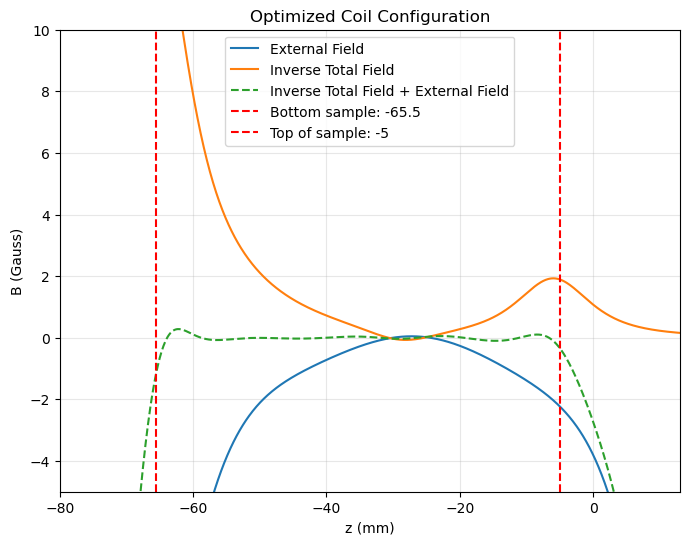

Average value within sample: 0.06237092946165288
Peak positive value within sample: 0.2808570523110614
Peak negative value within sample: 1.0865805272768458
Optimized parameters for Coil 1 to produce inverse field:
Current: -500.0 mA
Radius: 3.5 mm
Turns: 21.0
Z Offset: -68.92953930382338 mm
Layers: 1.0
Length of Coil 1: 10.72134 mm

Optimized parameters for Coil 2 to produce inverse field:
Current: -500.0 mA
Radius: 4.038261921951064 mm
Turns: 5.0
Z Offset: -5.946040826949478 mm
Layers: 1.0
Length of Coil 2: 2.5526999999999997 mm

Optimized parameters for Coil 3 to produce inverse field:
Current: -500.0 mA
Radius: 8.893083702456158 mm
Turns: 8.0
Z Offset: -59.39010679388891 mm
Layers: 1.0
Length of Coil 3: 4.08432 mm

Optimized parameters for Coil 4 to produce inverse field:
Current: -500.0 mA
Radius: 3.5 mm
Turns: 44.0
Z Offset: -73.97429763201647 mm
Layers: 1.0
Length of Coil 4: 22.46376 mm

Optimized parameters for Coil 5 to produce inverse field:
Current: 124.51557131992382 mA
Rad

In [5]:
# Recompute the optimised coil field on the full plotting grid
total_B_field_inverse = np.zeros_like(z_values)
for param in optimized_params_inverse_field:
    a, R, n, z0, m = param
    total_B_field_inverse += biot_savart(z_values, R, a, int(n), z0, int(m))

# Combined response for inspection (inverse coils intended to cancel external)
total_field_plus_external = total_B_field_inverse - external_field(z_values)

# Visual comparison: target vs. coil response vs. sum
plt.figure(figsize=(8, 6))
plt.plot(z_values, external_field(z_values),         label='External Field')
plt.plot(z_values, -total_B_field_inverse,           label='Inverse Total Field')
plt.plot(z_values, -total_field_plus_external, '--', label='Inverse Total Field + External Field')
plt.axvline(x=z_bottom_sample, linestyle='--', color='red', label=f'Bottom sample: {z_bottom_sample}')
plt.axvline(x=z_top_sample,    linestyle='--', color='red', label=f'Top of sample: {z_top_sample}')
plt.xlabel('z (mm)')
plt.ylabel('B (Gauss)')
plt.xlim(z_min, z_max)
plt.ylim(B_min, B_max)
plt.title('Optimized Coil Configuration')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Error statistics over the solve interval (smaller is better for cancellation)
mask = (z_values >= z_bottom_sample) & (z_values <= z_top_sample)
avg_abs = np.mean(np.abs(total_field_plus_external[mask]))
peak_pos = abs(np.min(total_field_plus_external[mask]))
peak_neg = abs(np.max(total_field_plus_external[mask]))

print(f"Average value within sample: {avg_abs}")
print(f"Peak positive value within sample: {peak_pos}")
print(f"Peak negative value within sample: {peak_neg}")

# Tabulate per-coil results for quick sanity checks and fabrication estimates
for i, param in enumerate(optimized_params_inverse_field, start=1):
    a, R, n, z0, m = param
    print(f"Optimized parameters for Coil {i} to produce inverse field:")
    print(f"Current: {a} mA")
    print(f"Radius: {R} mm")
    print(f"Turns: {n}")
    print(f"Z Offset: {z0} mm")
    print(f"Layers: {m}")
    length_mm = d * n * 1e3                                # axial build length estimate ~ d × turns
    print(f"Length of Coil {i}: {length_mm} mm")
    print()
